In [3]:
###This metric shows the percentage of toxic messages per month in a repo###
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import json
warnings.filterwarnings('ignore')

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [2]:
###USER PICKS REPO TO MEASURE THIS METRIC###
repoName = input("input repo name:")

input repo name: Loris


In [4]:
###This gathers the average sentiment scores for every message in the history of the repo and orders them by month###
repolist = pd.DataFrame()

repo_query = salc.sql.text(f"""
            SELECT
                repo.repo_id,
                repo.repo_name,
                date_trunc( 'month', message.msg_timestamp ) AS message_month,
                message.cntrb_id, 
                AVG ( message_analysis.sentiment_score ) AS average_sentiment
            FROM
                repo, message_analysis, message, issue_message_ref, issues 
                where message_analysis.msg_id = message.msg_id 
                and 
                issue_message_ref.issue_id = issues.issue_id  
                AND
                issue_message_ref.msg_id = message.msg_id 
                AND
                issues.repo_id = repo.repo_id 
                AND
                repo.repo_name = '""" + repoName + """'
            GROUP BY
                repo.repo_id,
                repo.repo_name,
                message.msg_timestamp, 
                message.cntrb_id 
            ORDER BY
                message_month ASC,
                average_sentiment DESC,
                repo_id;
    """)

repolist = pd.read_sql(repo_query, con=engine)

display(repolist)

repolist.dtypes

,repo_id,repo_name,message_month,cntrb_id,average_sentiment
0,26188,Loris,2011-11-01,389737,0.000000
1,26188,Loris,2011-12-01,297227,0.592223
2,26188,Loris,2011-12-01,297227,0.000000
3,26188,Loris,2011-12-01,389737,0.000000
4,26188,Loris,2012-01-01,297199,0.730323
...,...,...,...,...,...
16132,26188,Loris,2020-10-01,389737,0.000000
16133,26188,Loris,2020-10-01,392424,0.000000
16134,26188,Loris,2020-10-01,392424,0.000000
16135,26188,Loris,2020-10-01,371123,-0.434527


repo_id                       int64
repo_name                    object
message_month        datetime64[ns]
cntrb_id                      int64
average_sentiment           float64
dtype: object

In [5]:
###This gathers all the possible months to be used for calculating percentages###
repolist2 = pd.DataFrame()

repo_query2 = salc.sql.text(f"""
            SELECT DISTINCT
                repo.repo_id,
                repo.repo_name,
                date_trunc( 'month', message.msg_timestamp ) AS message_month
            FROM
                repo, message_analysis, message, issue_message_ref, issues 
                where message_analysis.msg_id = message.msg_id 
                AND
                issue_message_ref.issue_id = issues.issue_id  
                AND
                issue_message_ref.msg_id = message.msg_id 
                AND
                issues.repo_id = repo.repo_id 
                AND
                repo.repo_name = '""" + repoName + """'
            GROUP BY
                repo.repo_id,
                repo.repo_name, 
                message.msg_timestamp
            ORDER BY
                message_month;
    """)

repolist2 = pd.read_sql(repo_query2, con=engine)

display(repolist2)

repolist2.dtypes

,repo_id,repo_name,message_month
0,26188,Loris,2011-11-01
1,26188,Loris,2011-12-01
2,26188,Loris,2012-01-01
3,26188,Loris,2012-02-01
4,26188,Loris,2012-04-01
...,...,...,...
102,26188,Loris,2020-06-01
103,26188,Loris,2020-07-01
104,26188,Loris,2020-08-01
105,26188,Loris,2020-09-01


repo_id                   int64
repo_name                object
message_month    datetime64[ns]
dtype: object

In [6]:
###This calculates the percent of toxic messages per month and stores each month's average in an array###
percent_by_month_array = np.zeros(len(repolist2.message_month))
i = 0
j = 0
while i < len(repolist2.message_month) - 1:
    month = repolist2.message_month[i]
    toxic_messages = 0
    total_messages = 0 #total messages for each month
    while repolist.message_month[j] == month:
        if repolist.average_sentiment[j] < 0:
            toxic_messages = toxic_messages + 1
        total_messages = total_messages + 1
        j = j + 1
    toxic_percent = toxic_messages/total_messages  #get average for that month
    percent_by_month_array[i] = toxic_percent * 100
    print("total messages for month:", repolist2.message_month[i], ":",  total_messages)
    i = i + 1
            

total messages for month: 2011-11-01 00:00:00 : 1
total messages for month: 2011-12-01 00:00:00 : 3
total messages for month: 2012-01-01 00:00:00 : 6
total messages for month: 2012-02-01 00:00:00 : 1
total messages for month: 2012-04-01 00:00:00 : 5
total messages for month: 2012-05-01 00:00:00 : 14
total messages for month: 2012-06-01 00:00:00 : 5
total messages for month: 2012-07-01 00:00:00 : 10
total messages for month: 2012-08-01 00:00:00 : 8
total messages for month: 2012-09-01 00:00:00 : 5
total messages for month: 2012-10-01 00:00:00 : 1
total messages for month: 2012-11-01 00:00:00 : 13
total messages for month: 2012-12-01 00:00:00 : 6
total messages for month: 2013-01-01 00:00:00 : 9
total messages for month: 2013-02-01 00:00:00 : 7
total messages for month: 2013-03-01 00:00:00 : 6
total messages for month: 2013-04-01 00:00:00 : 8
total messages for month: 2013-05-01 00:00:00 : 3
total messages for month: 2013-06-01 00:00:00 : 9
total messages for month: 2013-07-01 00:00:00 :

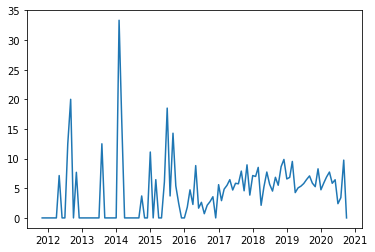

In [7]:
###This plots the percentage of toxic messages per month
plt.plot(repolist2.message_month, percent_by_month_array)